# 使用するパッケージの宣言

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 初期描画

In [2]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [4]:
ax  = fig.add_subplot('111')

## 赤い壁を描く

In [5]:
ax.plot([1, 1], [0, 1], color='red', linewidth=2)
ax.plot([1, 2], [2, 2], color='red', linewidth=2)
ax.plot([2, 2], [2, 1], color='red', linewidth=2)
ax.plot([2, 3], [1, 1], color='red', linewidth=2)

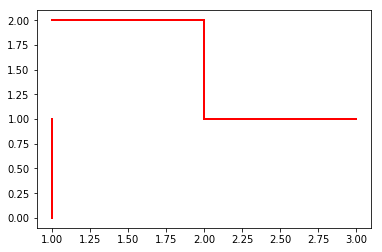

In [6]:
fig

## 状態を示す文字S0～S8を描く

In [7]:
ax.text(0.5, 2.5, 'S0', size=14, ha='center')
ax.text(1.5, 2.5, 'S1', size=14, ha='center')
ax.text(2.5, 2.5, 'S2', size=14, ha='center')
ax.text(0.5, 1.5, 'S3', size=14, ha='center')
ax.text(1.5, 1.5, 'S4', size=14, ha='center')
ax.text(2.5, 1.5, 'S5', size=14, ha='center')
ax.text(0.5, 0.5, 'S6', size=14, ha='center')
ax.text(1.5, 0.5, 'S7', size=14, ha='center')
ax.text(2.5, 0.5, 'S8', size=14, ha='center')
ax.text(0.5, 2.3, 'START', ha='center')
ax.text(2.5, 0.3, 'GOAL', ha='center')

Text(2.5, 0.3, 'GOAL')

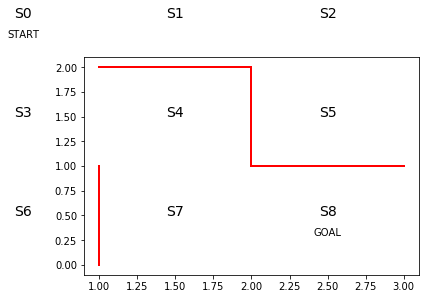

In [8]:
fig

## 描画範囲の設定と目盛りを消す設定

In [9]:
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

(0, 3)

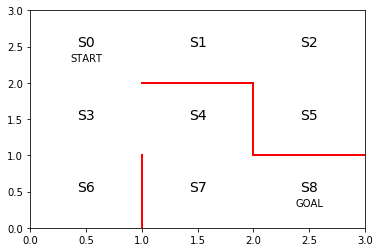

In [10]:
fig

In [11]:
ax.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

/home/toshinao/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


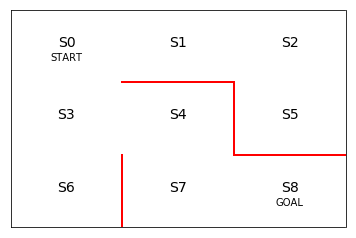

In [12]:
fig

## 現在地S0に緑丸を描画する

In [13]:
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

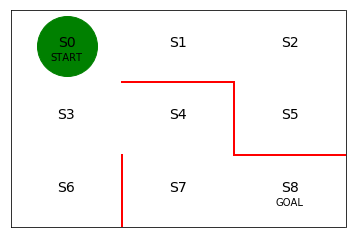

In [14]:
fig

# 初期の方策を決定するパラメータtheta_0を設定

行は状態0～7、列は移動方向で↑、→、↓、←を表す

In [16]:
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

# 方策パラメータthetaを行動方策piにソフトマックス関数で変換する手法の定義

In [18]:
def softmax_convert_into_pi_from_theta(theta):
    '''ソフトマックス関数で割合を計算する'''

    beta = 1.0
    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta)  # thetaをexp(theta)へと変換

    for i in range(0, m):
        # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        # simpleに割合の計算の場合

        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        # softmaxで計算の場合

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

# 初期の方策pi_0を求める

In [19]:
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


# 行動aと1step移動後の状態sを求める関数を定義

In [20]:
def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # pi[s,:]の確率に従って、directionが選択される
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return [action, s_next]

In [ ]:
np.random.choice?

In [23]:
np.random.choice(["A" , "B" , "C"] , p = [1/6,2/6,3/6])

'B'

# 迷路を解く関数の定義、状態と行動の履歴を出力

- (現在地、アクション）のペアを記録していく
- アクションは

|up|right|down|left|
|-|-|-|-|
|0|1|2|3|

- one pathに関して最初から最後まで求めてからthetaをアップデートするのがpolicy gradientの特徴
    - そうでないとアップデートできない

In [25]:
def goal_maze_ret_s_a(pi):
    s = 0  # スタート地点
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        # 現在の状態（つまり一番最後なのでindex=-1）の行動を代入

        s_a_history.append([next_s, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        if next_s == 8:  # ゴール地点なら終了
            break
        else:
            s = next_s

    return s_a_history

## SANDBOX

In [ ]:
s = 0
s_a_history = [[0,np.nan]]

In [ ]:
[action, next_s] = get_action_and_next_s(pi_0, s)

In [ ]:
next_s

In [ ]:
action

# 初期の方策で迷路を解く

In [26]:
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

[[0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 1], [4, 3], [3, 2], [6, 0], [3, 1], [4, 2], [7, 0], [4, 2], [7, 0], [4, 2], [7, 0], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
迷路を解くのにかかったステップ数は28です


# thetaの更新関数を定義します

- 与えられている遷移行列$p$の各要素と実際の遷移確率の差を用いて$p$のもとになるthetaをアップデートするイメージ


- ひとつのパスで同じノードを繰り返し訪れる
- そのパス内でのアクション選択確率は突っ込んだpiに依るので、基本的にはN_ij/N_i はpiとさほど乖離しないはず
- ただし、「正しい選択」をした場合は同じ所に戻ってくることが少ないはず
- こういうパス(i)ではN_ij/Niは「正しい選択(j)」に大きな重み付けをした形になっている
- したがって、そういうケースを利用して正しい選択への重み付けを増やす形で選択確率をアップデートしていっている

In [27]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学習率
    T = len(s_a_history) - 1  # ゴールまでの総ステップ数

    [m, n] = theta.shape  # thetaの行列サイズを取得
    delta_theta = theta.copy()  # Δthetaの元を作成、ポインタ参照なので、delta_theta = thetaはダメ

    # delta_thetaを要素ごとに求めます
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # thetaがnanでない場合

                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 履歴から状態iのものを取り出すリスト内包表記です

                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 状態iで行動jをしたものを取り出す

                N_i = len(SA_i)  # 状態iで行動した総回数
                N_ij = len(SA_ij)  # 状態iで行動jをとった回数
                
                # 初版では符号の正負に間違いがありました（修正日：180703）
                #delta_theta[i, j] = (N_ij + pi[i, j] * N_i) / T
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

    new_theta = theta + eta * delta_theta

    return new_theta

## 何をやっているかの考察

In [29]:
eta = 0.1 # 学習率
T = len(s_a_history) - 1  # ゴールまでの総ステップ数

In [30]:
T

28

In [31]:
theta = theta_0

|m|n|
|:-:|:-:|
|ノード数|各ノードでの可能なアクションのセットの数|

In [32]:
[m, n] = theta.shape  # thetaの行列サイズを取得
delta_theta = theta.copy()  # Δthetaの元を作成、ポインタ参照なので、delta_theta = thetaはダメ

In [ ]:
theta

In [ ]:
# delta_thetaを要素ごとに求めます
for i in range(0, m):
    for j in range(0, n):
        if not(np.isnan(theta[i, j])):  # thetaがnanでない場合

In [ ]:
i = 0
j = 2

In [ ]:
SA_i = [SA for SA in s_a_history if SA[0] == i]
# 履歴から状態iのものを取り出すリスト内包表記です

In [ ]:
"->".join([str(s[0]) for s in s_a_history])

In [ ]:
SA_i

In [ ]:
SA_ij = [SA for SA in s_a_history if SA == [i, j]]
# 状態iで行動jをしたものを取り出す

In [ ]:
SA_ij

In [ ]:
N_i = len(SA_i)  # 状態iで行動した総回数
N_ij = len(SA_ij)  # 状態iで行動jをとった回数

In [ ]:
N_i

In [ ]:
N_ij

In [ ]:
pi = pi_0

In [ ]:
pi[i,j]

In [ ]:
# 初版では符号の正負に間違いがありました（修正日：180703）
#delta_theta[i, j] = (N_ij + pi[i, j] * N_i) / T
delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

In [ ]:
new_theta = theta + eta * delta_theta


return new_theta

# 方策の更新

In [47]:
pi = pi_0
theta = theta_0

In [53]:
new_theta = update_theta(theta, pi, s_a_history)
pi2 = softmax_convert_into_pi_from_theta(new_theta)
print(pi2-pi)
pi = pi2
print(new_theta - theta)
theta = new_theta

[[ 0.          0.00086911 -0.00086911  0.        ]
 [ 0.          0.00085362  0.         -0.00085362]
 [ 0.          0.         -0.00260539  0.00260539]
 [-0.00152962  0.00076481  0.00076481  0.        ]
 [ 0.          0.          0.00337925 -0.00337925]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.002559   -0.002559    0.          0.        ]]
[[        nan  0.00173839 -0.00173839         nan]
 [        nan  0.00170741         nan -0.00170741]
 [        nan         nan -0.00521521  0.00521521]
 [-0.00465027  0.00232513  0.00232513         nan]
 [        nan         nan  0.00676847 -0.00676847]
 [ 0.                 nan         nan         nan]
 [ 0.                 nan         nan         nan]
 [ 0.00512227 -0.00512227         nan         nan]]


# 方策勾配法で迷路を解く

In [67]:
# 初版で、def update_thetaに間違いがあった関係で、終了条件を変更します（修正日：180703）
#stop_epsilon = 10**-8  # 10^-8よりも方策に変化が少なくなったら学習終了とする
stop_epsilon = 10**-4  # 10^-4よりも方策に変化が少なくなったら学習終了とする


theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:  # is_continueがFalseになるまで繰り返す
    s_a_history = goal_maze_ret_s_a(pi)  # 方策πで迷路内を探索した履歴を求める
    new_theta = update_theta(theta, pi, s_a_history)  # パラメータΘを更新
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  # 方策πの更新

    #print(np.sum(np.abs(new_pi - pi)))  # 方策の変化を出力
    #print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")
    print("[update L2 norm = {:.2E} / total steps = {}]".format(np.linalg.norm(new_pi - pi), len(s_a_history)-1) , end="  ==>  ")
    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

[update L2 norm = 4.65E-03 / total steps = 18]  ==>  [update L2 norm = 1.67E-02 / total steps = 4]  ==>  [update L2 norm = 4.79E-03 / total steps = 62]  ==>  [update L2 norm = 5.11E-03 / total steps = 34]  ==>  [update L2 norm = 4.17E-03 / total steps = 42]  ==>  [update L2 norm = 9.24E-03 / total steps = 18]  ==>  [update L2 norm = 2.36E-03 / total steps = 66]  ==>  [update L2 norm = 5.91E-03 / total steps = 18]  ==>  [update L2 norm = 5.37E-03 / total steps = 22]  ==>  [update L2 norm = 7.08E-03 / total steps = 20]  ==>  [update L2 norm = 6.42E-03 / total steps = 30]  ==>  [update L2 norm = 7.31E-03 / total steps = 24]  ==>  [update L2 norm = 2.14E-03 / total steps = 134]  ==>  [update L2 norm = 2.19E-03 / total steps = 56]  ==>  [update L2 norm = 1.86E-03 / total steps = 224]  ==>  [update L2 norm = 8.88E-03 / total steps = 22]  ==>  [update L2 norm = 6.33E-03 / total steps = 16]  ==>  [update L2 norm = 1.64E-02 / total steps = 10]  ==>  [update L2 norm = 1.63E-02 / total steps = 4]

  ==>  [update L2 norm = 7.43E-03 / total steps = 8]  ==>  [update L2 norm = 5.87E-03 / total steps = 10]  ==>  [update L2 norm = 6.86E-03 / total steps = 4]  ==>  [update L2 norm = 6.76E-03 / total steps = 4]  ==>  [update L2 norm = 6.82E-03 / total steps = 6]  ==>  [update L2 norm = 3.47E-03 / total steps = 10]  ==>  [update L2 norm = 7.78E-03 / total steps = 6]  ==>  [update L2 norm = 6.64E-03 / total steps = 4]  ==>  [update L2 norm = 6.65E-03 / total steps = 22]  ==>  [update L2 norm = 8.09E-03 / total steps = 10]  ==>  [update L2 norm = 4.81E-03 / total steps = 8]  ==>  [update L2 norm = 7.38E-03 / total steps = 12]  ==>  [update L2 norm = 6.65E-03 / total steps = 4]  ==>  [update L2 norm = 5.84E-03 / total steps = 10]  ==>  [update L2 norm = 5.81E-03 / total steps = 10]  ==>  [update L2 norm = 6.35E-03 / total steps = 12]  ==>  [update L2 norm = 6.63E-03 / total steps = 4]  ==>  [update L2 norm = 6.53E-03 / total steps = 4]  ==>  [update L2 norm = 6.64E-03 / total steps = 6]  ==

[update L2 norm = 1.07E-03 / total steps = 4]  ==>  [update L2 norm = 2.72E-03 / total steps = 6]  ==>  [update L2 norm = 1.08E-03 / total steps = 4]  ==>  [update L2 norm = 1.07E-03 / total steps = 4]  ==>  [update L2 norm = 1.06E-03 / total steps = 4]  ==>  [update L2 norm = 3.09E-03 / total steps = 6]  ==>  [update L2 norm = 1.05E-03 / total steps = 4]  ==>  [update L2 norm = 2.83E-03 / total steps = 6]  ==>  [update L2 norm = 1.05E-03 / total steps = 4]  ==>  [update L2 norm = 1.05E-03 / total steps = 4]  ==>  [update L2 norm = 3.26E-03 / total steps = 6]  ==>  [update L2 norm = 1.05E-03 / total steps = 4]  ==>  [update L2 norm = 4.41E-03 / total steps = 8]  ==>  [update L2 norm = 1.05E-03 / total steps = 4]  ==>  [update L2 norm = 3.20E-03 / total steps = 8]  ==>  [update L2 norm = 3.16E-03 / total steps = 6]  ==>  [update L2 norm = 2.69E-03 / total steps = 6]  ==>  [update L2 norm = 1.06E-03 / total steps = 4]  ==>  [update L2 norm = 2.71E-03 / total steps = 6]  ==>  [update L2 n

[update L2 norm = 4.84E-04 / total steps = 4]  ==>  [update L2 norm = 4.82E-04 / total steps = 4]  ==>  [update L2 norm = 4.79E-04 / total steps = 4]  ==>  [update L2 norm = 4.77E-04 / total steps = 4]  ==>  [update L2 norm = 4.74E-04 / total steps = 4]  ==>  [update L2 norm = 4.71E-04 / total steps = 4]  ==>  [update L2 norm = 2.19E-03 / total steps = 6]  ==>  [update L2 norm = 1.97E-03 / total steps = 6]  ==>  [update L2 norm = 4.76E-04 / total steps = 4]  ==>  [update L2 norm = 4.74E-04 / total steps = 4]  ==>  [update L2 norm = 2.45E-03 / total steps = 6]  ==>  [update L2 norm = 4.77E-04 / total steps = 4]  ==>  [update L2 norm = 4.75E-04 / total steps = 4]  ==>  [update L2 norm = 4.72E-04 / total steps = 4]  ==>  [update L2 norm = 4.70E-04 / total steps = 4]  ==>  [update L2 norm = 4.67E-04 / total steps = 4]  ==>  [update L2 norm = 4.65E-04 / total steps = 4]  ==>  [update L2 norm = 4.62E-04 / total steps = 4]  ==>  [update L2 norm = 4.60E-04 / total steps = 4]  ==>  [update L2 n

  ==>  [update L2 norm = 1.91E-04 / total steps = 4]  ==>  [update L2 norm = 1.91E-04 / total steps = 4]  ==>  [update L2 norm = 1.90E-04 / total steps = 4]  ==>  [update L2 norm = 1.89E-04 / total steps = 4]  ==>  [update L2 norm = 1.89E-04 / total steps = 4]  ==>  [update L2 norm = 1.88E-04 / total steps = 4]  ==>  [update L2 norm = 1.87E-04 / total steps = 4]  ==>  [update L2 norm = 1.87E-04 / total steps = 4]  ==>  [update L2 norm = 1.86E-04 / total steps = 4]  ==>  [update L2 norm = 1.85E-04 / total steps = 4]  ==>  [update L2 norm = 1.85E-04 / total steps = 4]  ==>  [update L2 norm = 1.28E-03 / total steps = 6]  ==>  [update L2 norm = 1.86E-04 / total steps = 4]  ==>  [update L2 norm = 1.85E-04 / total steps = 4]  ==>  [update L2 norm = 1.85E-04 / total steps = 4]  ==>  [update L2 norm = 1.84E-04 / total steps = 4]  ==>  [update L2 norm = 1.84E-04 / total steps = 4]  ==>  [update L2 norm = 1.83E-04 / total steps = 4]  ==>  [update L2 norm = 1.82E-04 / total steps = 4]  ==>  [upda

  ==>  [update L2 norm = 3.51E-03 / total steps = 6]  ==>  [update L2 norm = 1.11E-03 / total steps = 6]  ==>  [update L2 norm = 1.28E-04 / total steps = 4]  ==>  [update L2 norm = 1.28E-04 / total steps = 4]  ==>  [update L2 norm = 1.27E-04 / total steps = 4]  ==>  [update L2 norm = 1.27E-04 / total steps = 4]  ==>  [update L2 norm = 3.49E-03 / total steps = 6]  ==>  [update L2 norm = 1.29E-04 / total steps = 4]  ==>  [update L2 norm = 1.29E-04 / total steps = 4]  ==>  [update L2 norm = 1.28E-04 / total steps = 4]  ==>  [update L2 norm = 1.28E-04 / total steps = 4]  ==>  [update L2 norm = 1.28E-04 / total steps = 4]  ==>  [update L2 norm = 1.27E-04 / total steps = 4]  ==>  [update L2 norm = 1.27E-04 / total steps = 4]  ==>  [update L2 norm = 1.27E-04 / total steps = 4]  ==>  [update L2 norm = 1.26E-04 / total steps = 4]  ==>  [update L2 norm = 1.19E-03 / total steps = 6]  ==>  [update L2 norm = 1.27E-04 / total steps = 4]  ==>  [update L2 norm = 1.26E-04 / total steps = 4]  ==>  [upda

[update L2 norm = 1.01E-03 / total steps = 6]  ==>  [update L2 norm = 9.31E-05 / total steps = 4]  ==>  [update L2 norm = 9.29E-05 / total steps = 4]  ==>  [update L2 norm = 9.26E-05 / total steps = 4]  ==>  [update L2 norm = 9.24E-05 / total steps = 4]  ==>  [update L2 norm = 3.41E-03 / total steps = 6]  ==>  [update L2 norm = 9.47E-05 / total steps = 4]  ==>  [update L2 norm = 9.44E-05 / total steps = 4]  ==>  [update L2 norm = 9.42E-05 / total steps = 4]  ==>  [update L2 norm = 9.39E-05 / total steps = 4]  ==>  [update L2 norm = 9.37E-05 / total steps = 4]  ==>  [update L2 norm = 9.35E-05 / total steps = 4]  ==>  [update L2 norm = 9.32E-05 / total steps = 4]  ==>  [update L2 norm = 9.30E-05 / total steps = 4]  ==>  [update L2 norm = 9.27E-05 / total steps = 4]  ==>  [update L2 norm = 9.25E-05 / total steps = 4]  ==>  [update L2 norm = 9.23E-05 / total steps = 4]  ==>  [update L2 norm = 9.20E-05 / total steps = 4]  ==>  [update L2 norm = 9.18E-05 / total steps = 4]  ==>  [update L2 n

  ==>  [update L2 norm = 5.76E-05 / total steps = 4]  ==>  [update L2 norm = 5.74E-05 / total steps = 4]  ==>  [update L2 norm = 5.73E-05 / total steps = 4]  ==>  [update L2 norm = 5.72E-05 / total steps = 4]  ==>  [update L2 norm = 5.71E-05 / total steps = 4]  ==>  [update L2 norm = 5.70E-05 / total steps = 4]  ==>  [update L2 norm = 5.69E-05 / total steps = 4]  ==>  [update L2 norm = 5.68E-05 / total steps = 4]  ==>  [update L2 norm = 5.67E-05 / total steps = 4]  ==>  [update L2 norm = 5.66E-05 / total steps = 4]  ==>  [update L2 norm = 5.64E-05 / total steps = 4]  ==>  [update L2 norm = 5.63E-05 / total steps = 4]  ==>  [update L2 norm = 5.62E-05 / total steps = 4]  ==>  [update L2 norm = 5.61E-05 / total steps = 4]  ==>  [update L2 norm = 5.60E-05 / total steps = 4]  ==>  [update L2 norm = 5.59E-05 / total steps = 4]  ==>  [update L2 norm = 8.23E-04 / total steps = 6]  ==>  [update L2 norm = 5.63E-05 / total steps = 4]  ==>  [update L2 norm = 5.62E-05 / total steps = 4]  ==>  [upda

[update L2 norm = 3.97E-05 / total steps = 4]  ==>  [update L2 norm = 3.96E-05 / total steps = 4]  ==>  [update L2 norm = 3.95E-05 / total steps = 4]  ==>  [update L2 norm = 3.95E-05 / total steps = 4]  ==>  [update L2 norm = 3.02E-03 / total steps = 6]  ==>  [update L2 norm = 4.00E-05 / total steps = 4]  ==>  [update L2 norm = 3.99E-05 / total steps = 4]  ==>  [update L2 norm = 3.99E-05 / total steps = 4]  ==>  [update L2 norm = 3.98E-05 / total steps = 4]  ==>  [update L2 norm = 3.97E-05 / total steps = 4]  ==>  [update L2 norm = 3.97E-05 / total steps = 4]  ==>  [update L2 norm = 3.96E-05 / total steps = 4]  ==>  [update L2 norm = 3.95E-05 / total steps = 4]  ==>  [update L2 norm = 3.95E-05 / total steps = 4]  ==>  [update L2 norm = 3.94E-05 / total steps = 4]  ==>  [update L2 norm = 3.93E-05 / total steps = 4]  ==>  [update L2 norm = 3.93E-05 / total steps = 4]  ==>  [update L2 norm = 3.92E-05 / total steps = 4]  ==>  [update L2 norm = 3.91E-05 / total steps = 4]  ==>  [update L2 n

- 上記の例だとステップ数が（これ以上小さくしようがない）４でフィックスされることでthetaのアップデートはばが小さくなって学習が終わっている

# 最終的な方策を確認

In [ ]:
np.set_printoptions(precision=3, suppress=True)  # 有効桁数3、指数表示しないという設定
print(pi)

- 正しい手を打つ確率が１に非常に近くなっている

# エージェントの移動の様子を可視化します

In [ ]:
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    state = s_a_history[i][0]  # 現在の場所を描く
    x = (state % 3) + 0.5  # 状態のx座標は、3で割った余り+0.5
    y = 2.5 - int(state / 3)  # y座標は3で割った商を2.5から引く
    line.set_data(x, y)
    return (line,)


#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())

# sandbox

In [ ]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [ ]:
%%bash
git commit -a -m "moving on to 2_4"